# Exercise 1: Wealth dynamics with AR(1) returns

Recall the household wealth dynamics we studied in the previous lecture, where assets $a_{i,t}$ 
evolved according to
$$
a_{i,t+1} = R s a_{i,t} + y_{i,t+1}
$$
and we assumed a fixed savings rate $s$, a fixed gross return $R$
and some stochastic income process $y_{i,t}$.

In this exercise, we alter this setting to *stochastic returns* which follow an AR(1)
so that the model of wealth dynamics is now given by
$$
\begin{aligned}
a_{i,t+1} &= R_{i,t+1} s a_{i,t} + y_{i,t+1} \\
\log R_{i,t+1} &= \mu_r + \rho_r \log R_{i,t} + \epsilon_{i,t+1}\,, \qquad 
    \epsilon_{i,t+1} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, \sigma_r^2 \right) \\
\log y_{i,t+1} &\stackrel{\text{iid}}{\sim} \mathcal{N}\left(\mu_y, \sigma_y^2 \right)
\end{aligned}
$$
where $R_{i,t+1}$ follows an AR(1) in logs and $y_{i,t+1}$ is log-normally distributed.

## Parameters

To remain comparable with the scenarios discussed in the lecture, we set the following parameters:

| Parameter  | Description | Value       |
|------------|-------------|-------------|
| s | Savings rate | 0.75 |
| $\sigma_y$ | Volatility of log labor income | 0.1 |
| $\mu_y$ | Mean of log labor income | $-\frac{1}{2}\sigma_y^2$|
| $\rho_r$  | Autocorrelation of log returns | 0.6 |
| $\sigma_r$ | Volatility of log return shocks | 0.2 |
| $\mu_r$ | Intercept of log returns | $(1-\rho_r) \log(1.1) - \frac{1}{2}\frac{\sigma_r^2}{1+\rho_r}$

The parameter $\mu_y$ is chosen so that average income in levels is one, $\mathbb{E}[y_{i,t}] = 1$,
while $\mu_r$ is chosen so that average gross returns are 1.1 as in the lecture, i.e., $\mathbb{E}[R_{i,t}] = 1.1$.

The following code defines the parameters class for this problem:

In [1]:
import numpy as np
from dataclasses import dataclass


@dataclass
class Parameters:
    """
    Parameters for model with stochastic returns.
    """

    s: float = 0.75  # Exogenous savings rate
    sigma_y: float = 0.1  # Standard deviation of log income
    mu_y: float = -(sigma_y**2.0) / 2.0  # Mean of log income
    rho_r: float = 0.6  # Persistence of log gross returns
    sigma_r: float = 0.2  # Standard deviation of log gross returns
    mu_r: float = (1 - rho_r) * np.log(1.1) - sigma_r**2 / 2 / (
        1 + rho_r
    )  # Mean of log gross returns

In [2]:
# Create an instance of the Parameters class
par = Parameters()

The following code verifies that the calibration of parameters yields the desired moments $E[y_{i,t}] = 1$ and $E[R_{i,t}] = 1.1$. For this we use the formulas for the mean and variance of log-normal variables,
$$
\begin{aligned}
    \log X \stackrel{\text{iid}}{\sim} \mathcal{N}\left(\mu, \sigma^2 \right)
    \quad\Longrightarrow\quad

    \begin{cases}
    \mathbb{E}[X] &= e^{ \mu + \frac{1}{2}\sigma^2} \\
    \text{Var}(X) &= \left( e^{\sigma^2} - 1 \right) e^{2 \mu + \sigma^2}
    \end{cases}
\end{aligned}
$$

In [3]:
# Mean of income in levels (from log-normal formula)
y_mean = np.exp(par.mu_y + par.sigma_y**2 / 2)

# From the formulas for mean & variance of AR(1) process:
# Unconditional mean of log gross returns
uncond_mean_log_R = par.mu_r / (1 - par.rho_r)
# Unconditional variance of log gross returns
uncond_var_log_R = par.sigma_r**2 / (1 - par.rho_r**2)

# Unconditional mean of gross returns (from log-normal formula)
R_mean = np.exp(uncond_mean_log_R + uncond_var_log_R / 2)

print(f"Mean income:       {y_mean:.3f}")
print(f"Mean gross return: {R_mean:.3f}")

Mean income:       1.000
Mean gross return: 1.100


Lastly, we can use the variance formula above to get an idea of the conditional standard deviation of returns:

In [4]:
# Use variance formula for log-normal random variables
R_var_cond = (np.exp(par.sigma_r**2) - 1) * np.exp(2 * par.mu_r + par.sigma_r**2)
print(f"Conditional standard deviation of gross returns: {np.sqrt(R_var_cond):.3f}")

Conditional standard deviation of gross returns: 0.211


This value is slightly higher that the volatility of annual returns of the S&P500, but still within reasonable bounds.

## Tasks

We are interested in simulating the wealth dynamics and compute the Gini coefficient using the same approach as we did in the lecture.

1.  Simulate gross returns for 1,000,000 periods and compute the unconditional mean. Verify that this mean is close to the calibration target of 1.1.

    *Hint:* Use the `simulate_ar1()` function for this purpose. This function is replicated in the module `workshop08_ex1.py` for convenience.
    
2.  Write a function `simulate_wealth()` to simulate the wealth trajectories of a panel of households who face AR(1) returns. The function signature should look
    as follows:

    ```python
    def simulate_wealth(par: Parameters, a0, T, N, rng=None):
        """
        Simulate the evolution of wealth when returns are stochastic.

        Parameters
        ----------
        par : Parameters
        a0 : float
            Initial wealth.
        T : int
            Number of time periods to simulate.
        N : int
            Number of individuals to simulate.
        rng : numpy.random.Generator, optional
            A random number generator instance.

        Returns
        -------
        a_sim : numpy.ndarray
            A (T+1, N) array of simulated wealth paths.
        """
    ```

    Set the initial value of $\log R_{i,t}$ to the unconditional mean $\frac{\mu_r}{1-\rho_r}$ for all households.

    *Hint:* Use the wealth simulation routine from the lecture as a template and make the necessary changes.

3.  Using an initial wealth of $a_0 = 1$ for all households, simulate $N=20$ households for $T=100$ periods. 
    Plot the wealth trajectories for these households in a single graph and also include the average simulated wealth.

4.  Simulate a larger panel of $N=1,000,000$ households for $T=200$ periods. Compute the cross-sectional mean and variance
    of wealth for each period $t$ and plot these in a figure with two subplots (one for the mean, one for the variance).
    
    How do these plots compare to the scenarios (with IID and AR(1) income) discussed in the lecture?

5.  From the previous plots you suspect that the Gini coefficient changes somewhat across periods.
    Compute a cross-sectional Gini coefficients each of the last 100 periods of your simulation
    and plot these Ginis as a time series. Add a horizontal line indicating the average Gini coefficient.

    *Hint:* Use the `gini()` function from the `workshop08_ex1` module for this purpose.

In [5]:
# Enable automatic reloading of external modules
%load_ext autoreload
%autoreload 2

In [6]:
from workshop08_ex1 import simulate_ar1, gini

# Number of periods to simulate
T = 1_000_000

# Initial value
log_x0 = 0.0

# Simulate AR(1) process
log_R = simulate_ar1(log_x0, par.mu_r, par.rho_r, par.sigma_r, T)

# Gross returns in levels
R = np.exp(log_R)

# Mean of simulated gross returns
R_mean_sim = R.mean()
print(f"Simulated mean gross return: {R_mean_sim:.6f}")

# Variance of simulated gross returns
R_var_sim = R.var()
print(f"Simulated variance of gross returns: {R_var_sim:.6f}")

Simulated mean gross return: 1.100659
Simulated variance of gross returns: 0.078258


In [7]:
def simulate_wealth(par: Parameters, a0, T, N, rng=None):
    """
    Simulate the evolution of wealth when returns are stochastic.

    Parameters
    ----------
    par : Parameters
    a0 : float
        Initial wealth.
    T : int
        Number of time periods to simulate.
    N : int
        Number of individuals to simulate.
    rng : numpy.random.Generator, optional
        A random number generator instance.

    Returns
    -------
    a_sim : numpy.ndarray
        A (T+1, N) array of simulated wealth paths.
    """
    if rng is None:
        rng = np.random.default_rng(seed=1234)

    # Random draws of IID income
    log_y = rng.normal(loc=par.mu_y, scale=par.sigma_y, size=(T, N))

    # Income in levels
    y = np.exp(log_y)

    # Create array to store the simulated wealth paths
    a_sim = np.zeros((T + 1, N))

    # Set initial value (identical for all households)
    a_sim[0] = a0

    # Draw innovation for log gross returns
    epsilon = rng.normal(loc=0, scale=par.sigma_r, size=(T, N))

    # Unconditional mean of log gross returns
    log_R_mean = par.mu_r / (1 - par.rho_r)

    # Array to store log gross returns for current period
    log_R = np.full(N, fill_value=log_R_mean)

    # Simulate wealth forward, one period at a time
    for t in range(T):
        # Savings out of beginning-of-period assets
        savings = par.s * a_sim[t]

        # Compute next period log gross returns
        log_R = par.mu_r + par.rho_r * log_R + epsilon[t]

        # Gross returns in levels
        R = np.exp(log_R)

        # Next-period assets
        a_sim[t + 1] = R * savings + y[t]

    return a_sim

In [8]:
# Intial wealth
a0 = 1.0

# Number of individuals to simulate
N = 20

# Number of periods to simulate
T = 100

# Simulate wealth paths
a_sim = simulate_wealth(par, a0, T, N)

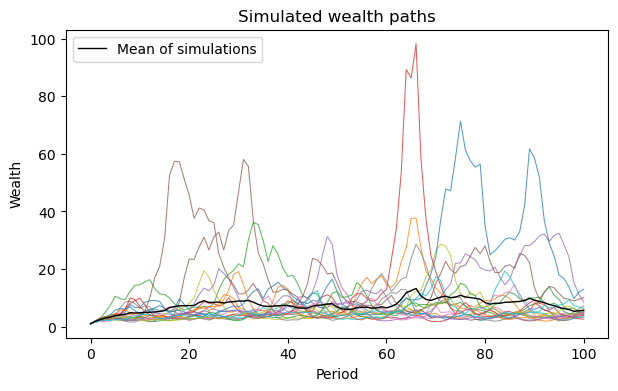

In [9]:
# Plot the simulated wealth paths in a single graph
# and include the average wealth path
import matplotlib.pyplot as plt

# Average wealth path
a_sim_mean = np.mean(a_sim, axis=1)

plt.figure(figsize=(7, 4))
plt.plot(a_sim, alpha=0.75, lw=0.75)

plt.xlabel("Period")
plt.ylabel("Wealth")
plt.title("Simulated wealth paths")
# Add average of simulated wealth paths
plt.plot(a_sim_mean, color="black", ls="-", lw=1, label="Mean of simulations")
plt.legend(loc="upper left")

In [12]:
# Number of households to simulate
N = 1_000_000

# Number of periods to simulate
T = 200

# Simulate wealth paths
a_sim = simulate_wealth(par, a0, T, N)

In [16]:
sim_mean = np.mean(a_sim, axis=1)
sim_var = np.var(a_sim, axis=1)

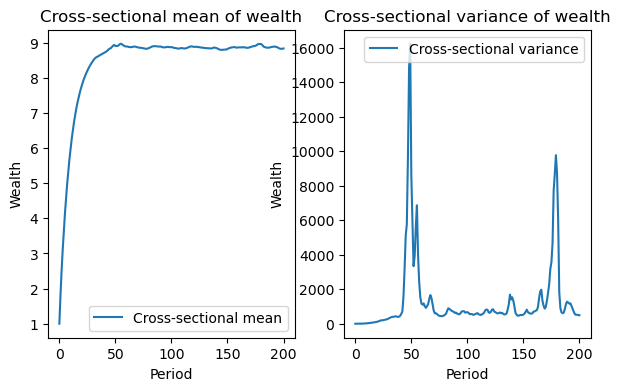

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.plot(sim_mean, label="Cross-sectional mean")
ax1.set_title("Cross-sectional mean of wealth")
ax1.set_xlabel("Period")
ax1.set_ylabel("Wealth")
ax1.legend()

ax2.plot(sim_var, label="Cross-sectional variance")
ax2.set_title("Cross-sectional variance of wealth")
ax2.set_xlabel("Period")
ax2.set_ylabel("Wealth")
ax2.legend()

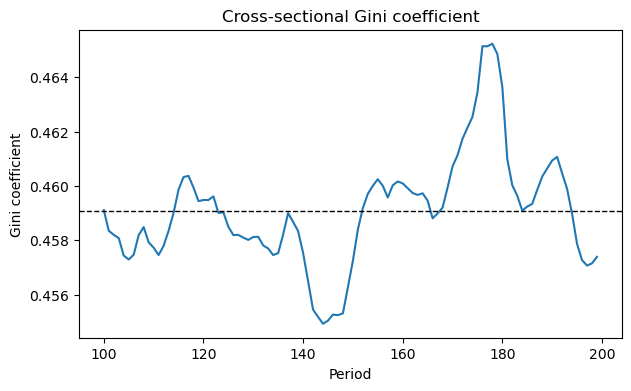

In [22]:
# Cross-sectional Gini coefficients off the last 100 periods
gini_coeffs = np.zeros(100)

for i, t in enumerate(range(-100, 0)):
    gini_coeffs[t] = gini(a_sim[t])

G_mean = np.mean(gini_coeffs)

plt.figure(figsize=(7, 4))
plt.plot(range(T - 100, T), gini_coeffs)
plt.xlabel("Period")
plt.ylabel("Gini coefficient")
plt.title("Cross-sectional Gini coefficient")
plt.axhline(G_mean, color="black", ls="--", lw=1, label="Mean Gini")

***
# Exercise 2: AR(1) vs Random Walk

Recall the AR(1) process we studied in the lecture, defined as 
$$
x_{i,t+1} = \rho x_{i,t} + \epsilon_{i,t+1}\,, \qquad \epsilon_{t+1} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, \sigma^2\right)
$$
In the lecture, we restricted our attention to the stationary case with $\rho \in (-1, 1)$. With $\rho = 1$, the above process is called a Random walk
which is no longer stationary as its variance is linearly increasing in time.

To demonstrate this, perform the following tasks:

1. Write a function `simulate_panel()` which simulates a *panel* of individuals $i$ where each individual-specific realization $x_{i,t}$ follows the
    stochastic process defined above. The function signature should look as follows:

    ```python
    def simulate_panel(rho, sigma, T, N, x0=0, rng=None):
        """
        Simulates a panel of stochastic processes.

        Parameters
        ----------
        rho : float
            The autoregressive parameter.
        sigma : float
            The standard deviation of the noise term.
        T : int
            The number of time periods to simulate.
        N : int
            The number of individuals to simulate.
        x0 : float, optional
            The initial value of the process.
        rng : Generator, optional
            Random number generator to use.

        Returns
        -------
        numpy.ndarray
            A (T+1, N) array with the simulated values.
        """
    ```
2. Let $\sigma=0.1$. Simulate the trajectories of a cross section of $N=100,000$ individuals for $T=300$ periods for two different scenarios:

    1.  AR(1) with $\rho = 0.9$;
    2.  Random walk with $\rho = 1$

    Make sure to use the same seed for both simulations.


3.  Create a figure with two subplots:

    1.  The first subplot should contain two lines showing the average value of the simulated AR(1) and Random walk for each period $t$,
        i.e., average across $N$ individuals for each $t$.
    2.  The second subplot should contain two lines showing the variance of the simulated AR(1) and Random walk for each period $t$.

4.  Repeat the previous exercise, but use $\rho=0.99$ for the AR(1) instead. How does behavior of the cross-sectional mean and variance of the AR(1) change?